In [1]:
## imports
import sys
import os
import numpy as np
import xarray as xr
import cmocean
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib import gridspec
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import eofs
from eofs.xarray import Eof
import cftime
import nc_time_axis
import cmocean as cmo
import mtspec

# from pylab import *

import datetime
import time
import glob, os
import math
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
import xskillscore
from defs import trim_axs, amocstrength, corsst, pvalmask, lon180, detrend_dim
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator)
import cartopy.mpl.ticker as cticker
import matplotlib.ticker as mticker

In [2]:
folder = ''
modellist =   ['GISS2.1G', 'EC-Earth3-LR', 'CCSM4-UoT', 'CCSM4-Utr','CCSM4', 'CESM1.2', 'CESM2','IPSL-CM6A','MIROC4m','COSMOS', 'HadCM3', 'NorESM1-F','HadGEM3']

In [3]:
#Open one SST field to initialize field
model = modellist[0]
ds = xr.open_dataset(folder+model+'/E280/'+'SST_annual_100yr.nc')

#Initialize fields for correlation and pvalue
dsE280 = xr.Dataset(data_vars = dict(corr=(["model","lat", "lon"], np.zeros([len(modellist), len(ds.lat), len(ds.lon)]))), coords = dict(model = modellist,  lat = ds.lat.values, lon = ds.lon.values))
dsE280['pval'] = dsE280.corr.copy(deep=True)

dsEoi400 = dsE280.copy(deep=True)

#Compute correlation and p-value for every model and experiment
for i in range(len(modellist)):
    dsE280.corr[i,:,:], dsE280.pval[i,:,:] = corsst(modellist[i], 'E280')
    dsEoi400.corr[i, :,:], dsEoi400.pval[i,:,:] = corsst(modellist[i], 'Eoi400')

#Rewrite coordinates from -180 to 180 
dsE280 = lon180(dsE280)
dsEoi400 = lon180(dsEoi400)

In [4]:
#Construct 2D arrays of longitude and latitude to produce scatter plots for significance
lon = dsE280.lon
lat = dsE280.lat

coords = xr.Dataset(data_vars = dict(lat2D=(["lat", "lon"], np.repeat(lat.values[:, np.newaxis], len(lon), axis=1))), coords = dict(lat = lat.values, lon = lon.values))
coords['lon2D'] = coords.lat2D.copy(deep=True)
coords.lon2D[:] = np.transpose(np.repeat(lon.values[:, np.newaxis], len(lat), axis=1))

/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/cartopy/crs.py:239: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/cartopy/crs.py:239: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/opt/anaconda3/envs/myenv/lib/python3.

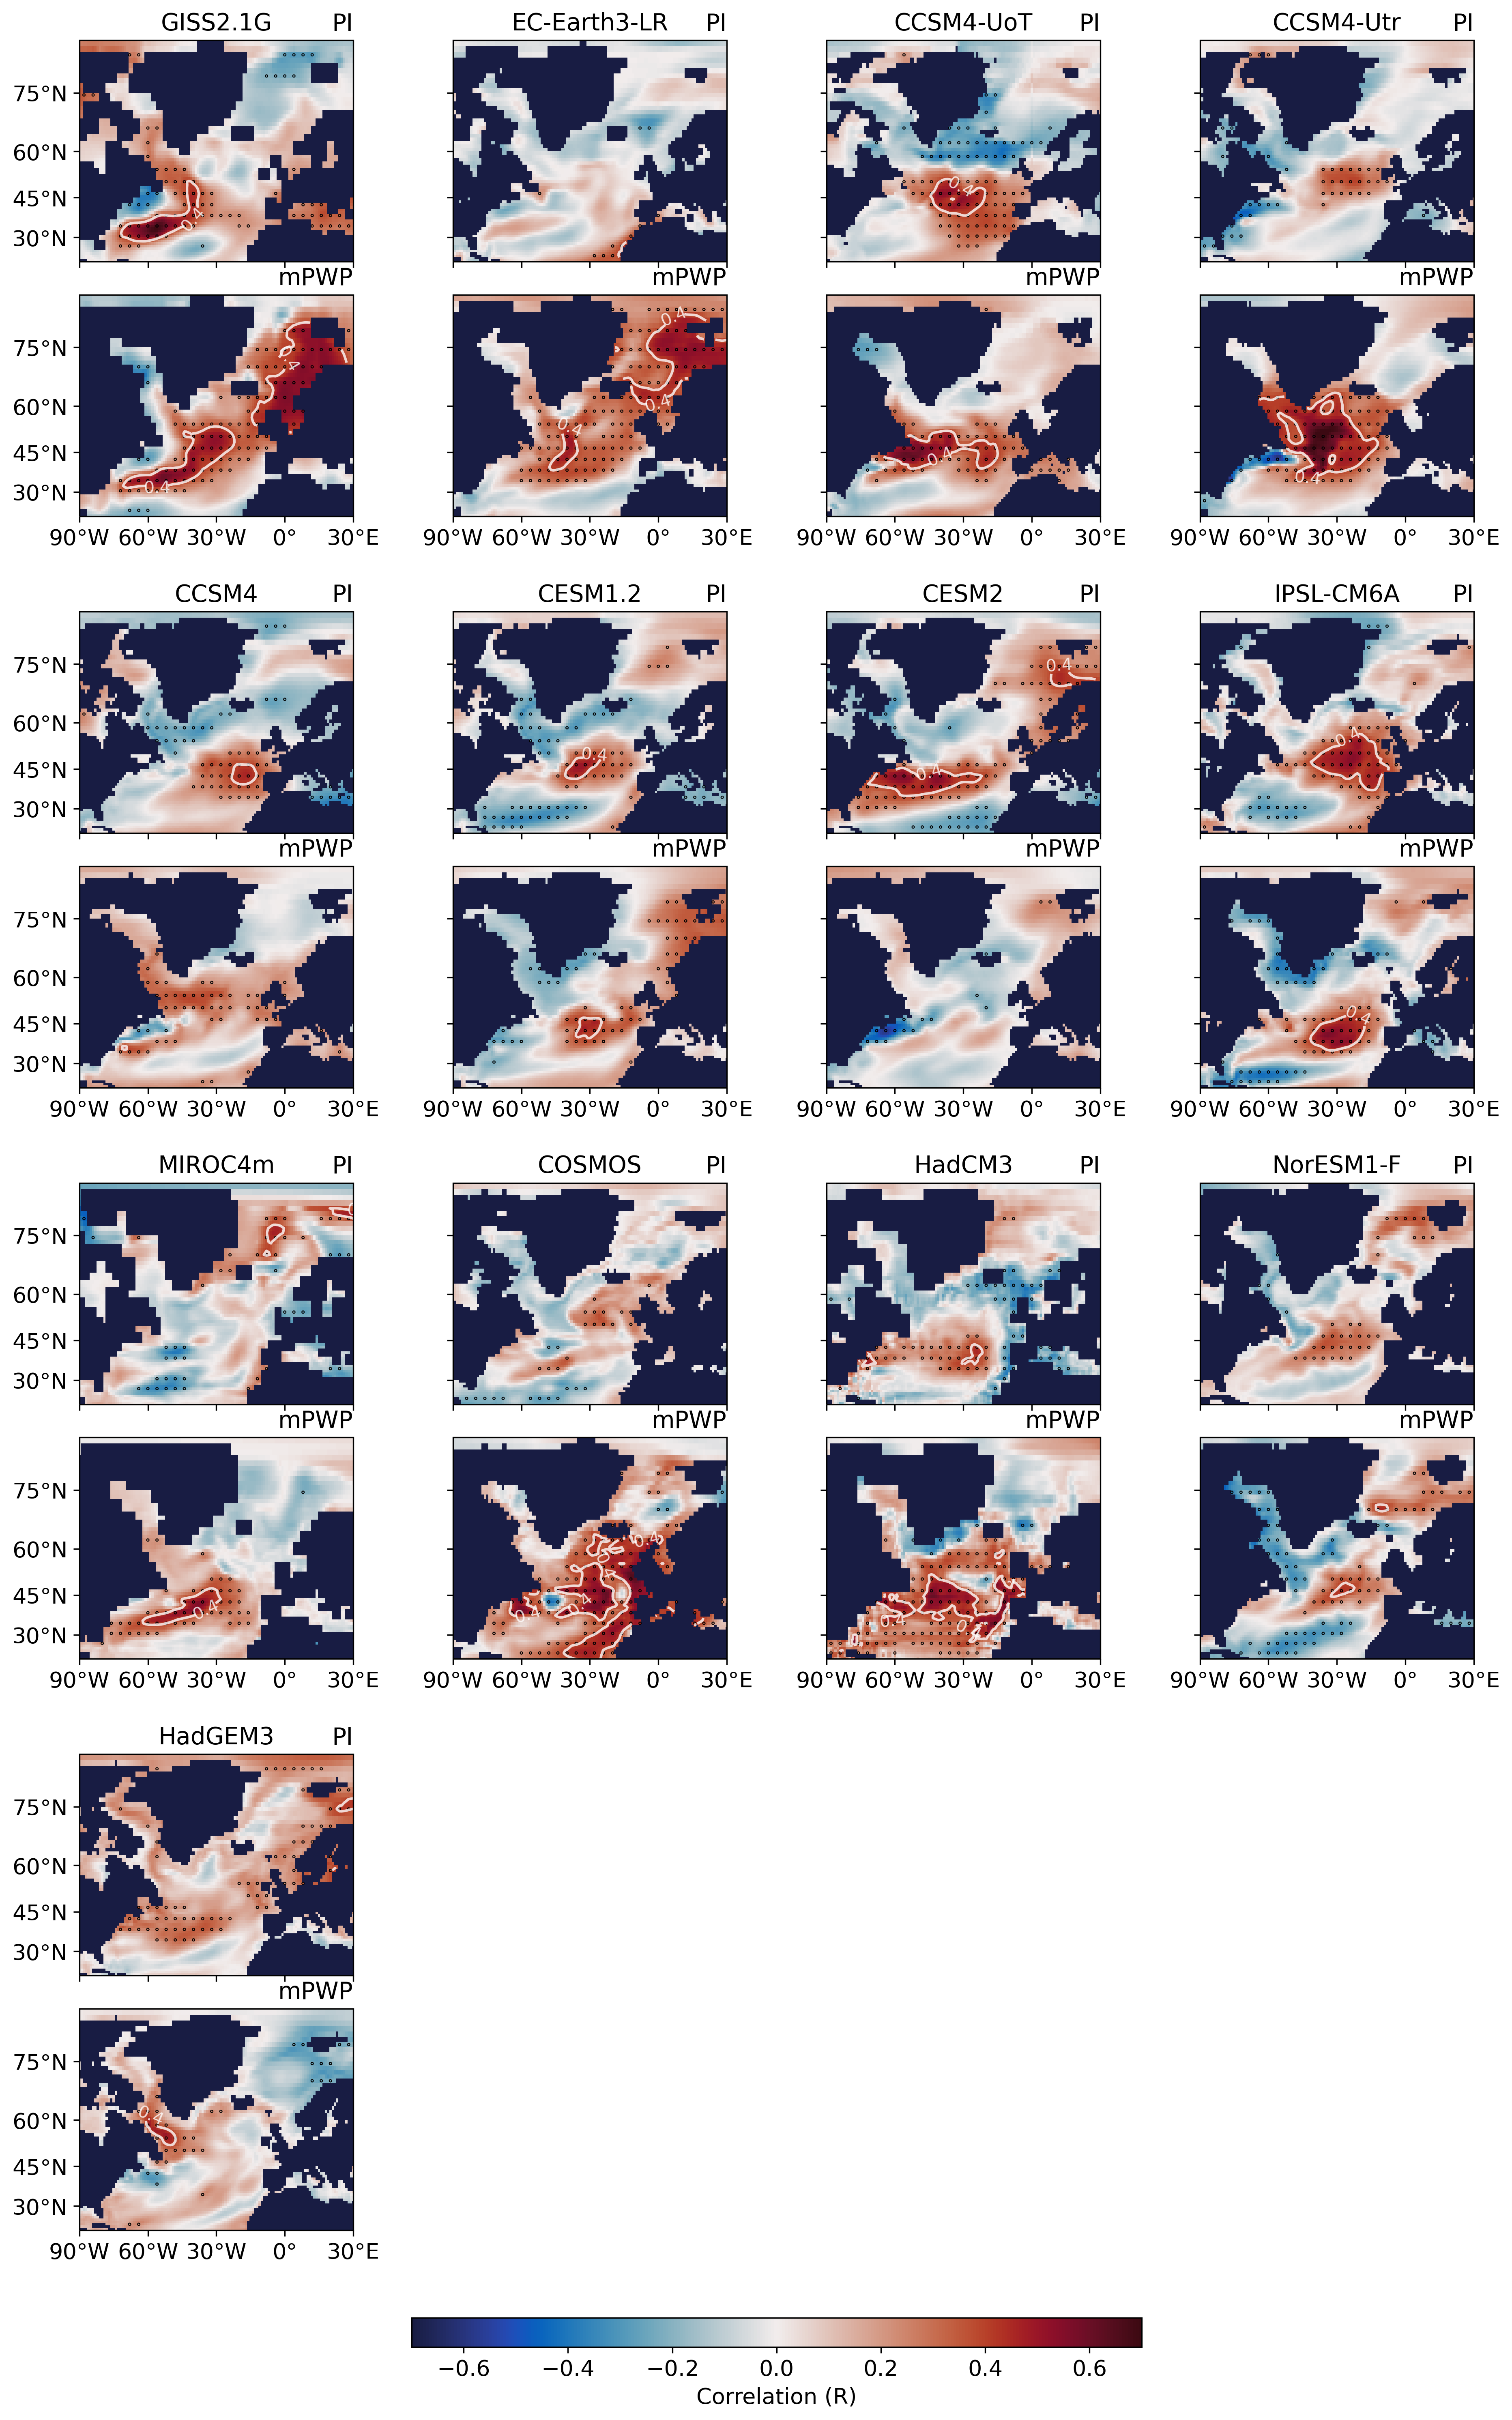

In [5]:
plt.rcParams['xtick.labelsize']=13
plt.rcParams['ytick.labelsize']=13
plt.rcParams['axes.labelsize'] = 13

fig = plt.figure(figsize=(15, 24), dpi=300)
outer = gridspec.GridSpec(4, 4, wspace=0.1, hspace=0.2)

mask = pvalmask(dsE280,0.05)
mask2 = pvalmask(dsEoi400,0.05)

for i in range(len(modellist)):
    inner = gridspec.GridSpecFromSubplotSpec(2, 1,
                    subplot_spec=outer[i], wspace=0.1, hspace=0.15)
    model = modellist[i]
    for j in range(2):
        ax = plt.subplot(inner[j], projection = ccrs.Miller())
        if j == 0:
            im = ax.pcolormesh(dsE280.lon, dsE280.lat, dsE280.corr[i].fillna(-1000), transform = ccrs.PlateCarree(), cmap='cmo.balance', shading='auto',vmin = -0.7, vmax = 0.7)
            cs = ax.scatter(coords.lon2D.where(mask[i]>0)[::4,::4], coords.lat2D.where(mask[i]>0)[::4,::4], transform = ccrs.PlateCarree(), s=2, facecolors='none', edgecolors='black', linewidth=0.5)
            cp1 = ax.contour(dsE280.lon, dsE280.lat, dsE280.corr[i], levels=[0.4, 1e24], colors='w', zorder =1, alpha=0.8,transform = ccrs.PlateCarree())
            ax.set_title(model, fontsize=14)
            ax.set_title('PI', fontsize=14, loc='right')
            ax.tick_params(labelbottom=False)   
        elif j==1:
            im = ax.pcolormesh(dsEoi400.lon, dsEoi400.lat, dsEoi400.corr[i].fillna(-1000), transform = ccrs.PlateCarree(), cmap='cmo.balance', shading='auto',vmin = -0.7, vmax = 0.7)
            cs = ax.scatter(coords.lon2D.where(mask2[i]>0)[::4,::4], coords.lat2D.where(mask2[i]>0)[::4,::4], transform = ccrs.PlateCarree(), s=2, facecolors='none', edgecolors='black', linewidth=0.5)
            cp1 = ax.contour(dsEoi400.lon, dsEoi400.lat, dsEoi400.corr[i], levels=[0.4, 1e24], colors='w', alpha=0.8,transform = ccrs.PlateCarree())
            ax.set_title('mPWP', fontsize=14, loc='right')
            #ax.set_xlabel('Longitude')
        if i!=0 and i!=4 and i!=8 and i !=12:
            ax.tick_params(labelleft=False)
            
        ax.set_extent([-90, 30, 20, 85], ccrs.PlateCarree())
        ax.clabel(cp1, inline=True, inline_spacing=0.1, fmt = '%.1f',  fontsize=10)
        
        ax.set_xticks(np.arange(-90,31,30), crs=ccrs.PlateCarree())
        lon_formatter = cticker.LongitudeFormatter()
        ax.xaxis.set_major_formatter(lon_formatter)

        ax.set_yticks(np.arange(30,80,15), crs=ccrs.PlateCarree())
        lat_formatter = cticker.LatitudeFormatter()
        ax.yaxis.set_major_formatter(lat_formatter)
        
        fig.add_subplot(ax)

fig.subplots_adjust(bottom=0.15, top=0.9, left=0.1, right=0.9)
    # Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.3, 0.11, 0.4, 0.01])
    # Draw the colorbar
cbar=fig.colorbar(im, cax=cbar_ax,orientation='horizontal', label='Correlation (R)', pad=0.01)
plt.savefig('fig03.png', bbox_inches='tight')

## Compute area of positive correlation, mean positive correlation and maximum correlation for all models

/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/regionmask/core/plot.py:12: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  coords += [np.asarray(p.exterior)[:, :2]] + [


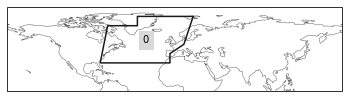

In [7]:
#Create 30-60N North Atlantic mask
import regionmask

Atlantic = np.array([[-80,30],[-72,70],[-40,70],[-40,80], [20,80],[10,50],[-5,40], [-5,30]])
region = regionmask.Regions([Atlantic])

ax = region.plot()
ax.set_extent([0, 350, 0, 90], crs=ccrs.PlateCarree())

# define lat/ lon grid
ds = xr.open_dataset(folder+model+'/Eoi400/'+'SST_annual_100yr.nc')
ds = lon180(ds)

maskA = region.mask(ds.lon.values, ds.lat.values)

In [13]:
#Count the number of positive significant grid cells in North Atlantic
mask = pvalmask(dsE280,0.05)
mask2 = pvalmask(dsEoi400, 0.05)

a = dsE280.corr.where(mask>0).where(maskA>-1).where(dsE280.corr>0)
b = dsEoi400.corr.where(mask2>0).where(maskA>-1).where(dsEoi400.corr>0)

pcountE280 = a.count(dim=['lon','lat'])
pcountEoi400 = b.count(dim=['lon','lat'])

#Compute total number of grid cells in North Atlantic
totalE280 = dsE280.corr.where(maskA>-1).count(dim=['lon','lat'])
totalEoi400 = dsE280.corr.where(maskA>-1).count(dim=['lon','lat'])

perE280 = pcountE280/totalE280*100
perEoi400 = pcountEoi400/totalEoi400*100

print(modellist)
print(perE280)
print(perEoi400)

['GISS2.1G', 'EC-Earth3-LR', 'CCSM4-UoT', 'CCSM4-Utr', 'CCSM4', 'CESM1.2', 'CESM2', 'IPSL-CM6A', 'MIROC4m', 'COSMOS', 'HadCM3', 'NorESM1-F', 'HadGEM3']
<xarray.DataArray 'corr' (model: 13)>
array([28.13178856,  0.94959825, 29.68095392, 10.7027027 , 19.17117117,
       16.68468468, 40.43243243, 31.76725696,  9.4905792 , 12.22690686,
       20.01437298, 19.78107897, 29.30972172])
Coordinates:
  * model    (model) <U12 'GISS2.1G' 'EC-Earth3-LR' ... 'NorESM1-F' 'HadGEM3'
<xarray.DataArray 'corr' (model: 13)>
array([61.22375091, 64.86486486, 31.32452465, 51.96396396, 26.52252252,
       24.36036036,  1.94594595, 23.45500542, 26.02930914, 58.37485627,
       52.28171038, 20.05473026, 12.25153596])
Coordinates:
  * model    (model) <U12 'GISS2.1G' 'EC-Earth3-LR' ... 'NorESM1-F' 'HadGEM3'


In [14]:
#Compute weights for mean
weights = np.cos(np.deg2rad(ds.lat))
weights.name = "weights"

meanE280 = a.weighted(weights).mean(dim=['lon','lat'])
meanEoi400 = b.weighted(weights).mean(dim=['lon','lat'])

print(modellist)
print(meanE280)
print(meanEoi400)

['GISS2.1G', 'EC-Earth3-LR', 'CCSM4-UoT', 'CCSM4-Utr', 'CCSM4', 'CESM1.2', 'CESM2', 'IPSL-CM6A', 'MIROC4m', 'COSMOS', 'HadCM3', 'NorESM1-F', 'HadGEM3']
<xarray.DataArray 'corr' (model: 13)>
array([0.35488213, 0.24982893, 0.33982665, 0.2842618 , 0.30757512,
       0.31016344, 0.34591889, 0.35572255, 0.26750104, 0.25025871,
       0.29019309, 0.26824988, 0.25942811])
Coordinates:
  * model    (model) <U12 'GISS2.1G' 'EC-Earth3-LR' ... 'NorESM1-F' 'HadGEM3'
<xarray.DataArray 'corr' (model: 13)>
array([0.378502  , 0.323494  , 0.35739907, 0.40167568, 0.27323152,
       0.3058732 , 0.22446125, 0.35046958, 0.32671628, 0.38534465,
       0.36326957, 0.28715361, 0.28919912])
Coordinates:
  * model    (model) <U12 'GISS2.1G' 'EC-Earth3-LR' ... 'NorESM1-F' 'HadGEM3'


In [15]:
maxE280 = a.max(dim=['lon','lat'])
maxEoi400 = b.max(dim=['lon','lat'])

print(modellist)
print(maxE280)
print(maxEoi400)

['GISS2.1G', 'EC-Earth3-LR', 'CCSM4-UoT', 'CCSM4-Utr', 'CCSM4', 'CESM1.2', 'CESM2', 'IPSL-CM6A', 'MIROC4m', 'COSMOS', 'HadCM3', 'NorESM1-F', 'HadGEM3']
<xarray.DataArray 'corr' (model: 13)>
array([0.69135788, 0.36487549, 0.53849123, 0.39733436, 0.46039911,
       0.50108314, 0.55466867, 0.54498557, 0.47098031, 0.37604921,
       0.49182329, 0.37167912, 0.359411  ])
Coordinates:
  * model    (model) <U12 'GISS2.1G' 'EC-Earth3-LR' ... 'NorESM1-F' 'HadGEM3'
<xarray.DataArray 'corr' (model: 13)>
array([0.60029037, 0.54051508, 0.62169224, 0.72094765, 0.42591465,
       0.47901002, 0.2622767 , 0.56389474, 0.55422226, 0.65364142,
       0.60968716, 0.45354762, 0.50110977])
Coordinates:
  * model    (model) <U12 'GISS2.1G' 'EC-Earth3-LR' ... 'NorESM1-F' 'HadGEM3'


In [20]:
#Multi-model mean (excluding HadGEM3):
print(np.mean(perE280[:-1]))
print(np.mean(perEoi400[:-1]))
print(np.mean(meanE280[:-1]))
print(np.mean(meanEoi400[:-1]))
print(np.mean(maxE280[:-1]))
print(np.mean(maxEoi400[:-1]))

<xarray.DataArray 'corr' ()>
array(19.91946056)
<xarray.DataArray 'corr' ()>
array(36.86679539)
<xarray.DataArray 'corr' ()>
array(0.30203185)
<xarray.DataArray 'corr' ()>
array(0.33146587)
<xarray.DataArray 'corr' ()>
array(0.48031062)
<xarray.DataArray 'corr' ()>
array(0.54046999)
